In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
import pandas as pd

from sklearn import manifold

### Load sample data

In [2]:
filename = 'distance.csv'
reader = csv.reader(open(filename, 'r'), delimiter=';')
data = list(reader)

dists = []
cities = []
for d in data:
    cities.append(d[0])
    dists.append(list(map(float , d[1:-1])))

adist = np.array(dists)
amax = np.amax(adist)
adist /= amax

### Plot result

In [3]:
def plot_cities(coords, cities):
    plt.figure(figsize=(10,6))
    plt.scatter(coords[:, 0], coords[:, 1])
    for label, x, y in zip(cities, coords[:, 0], coords[:, 1]):
        plt.annotate(
            label,
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

### MDS

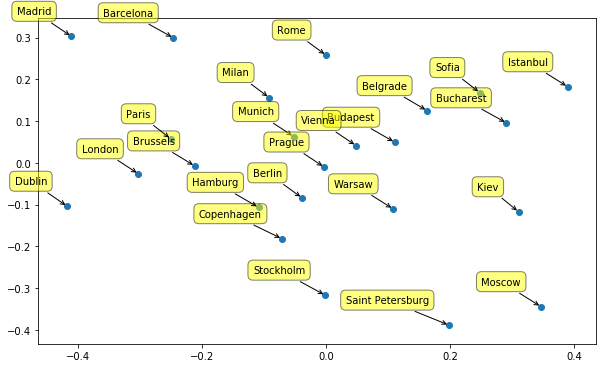

In [4]:
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=0)
coords = mds.fit_transform(adist)
plot_cities(coords, cities)

### t-SNE

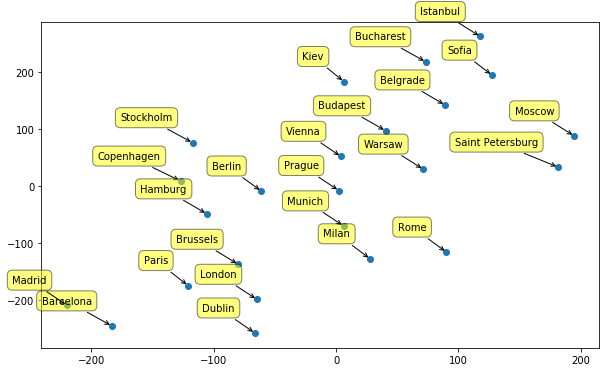

In [5]:
tsne = manifold.TSNE(n_components=2, metric='precomputed', perplexity=10, random_state=0)
coords = tsne.fit_transform(adist)
plot_cities(coords, cities)

---

I want to compute document similarity based on word2vec and check if documents discussing the same topic are similar.

In [6]:
import nlp
import json

### Load and clean the data

In [7]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

### LDA with 10 topics

In [8]:
lda = nlp.build_lda(docs, num_topics=10)
lda.print_topics()

[(0,
  '0.035*"palestinian" + 0.024*"israeli" + 0.020*"arafat" + 0.011*"said" + 0.011*"gaza" + 0.010*"hamas" + 0.009*"israel" + 0.007*"west" + 0.007*"official" + 0.007*"suicide"'),
 (1,
  '0.018*"say" + 0.012*"south" + 0.009*"australia" + 0.009*"new" + 0.009*"fire" + 0.007*"test" + 0.006*"said" + 0.005*"year" + 0.004*"wale" + 0.004*"sydney"'),
 (2,
  '0.017*"say" + 0.013*"said" + 0.007*"australian" + 0.006*"year" + 0.004*"per" + 0.004*"australia" + 0.004*"could" + 0.004*"child" + 0.004*"new" + 0.004*"cent"'),
 (3,
  '0.015*"said" + 0.010*"say" + 0.007*"attack" + 0.006*"palestinian" + 0.005*"state" + 0.005*"one" + 0.005*"two" + 0.005*"metre" + 0.004*"last" + 0.004*"first"'),
 (4,
  '0.016*"said" + 0.016*"say" + 0.012*"afghanistan" + 0.011*"force" + 0.011*"government" + 0.008*"bin" + 0.007*"qaeda" + 0.006*"laden" + 0.006*"taliban" + 0.006*"afghan"'),
 (5,
  '0.017*"say" + 0.014*"union" + 0.011*"worker" + 0.010*"qantas" + 0.008*"said" + 0.008*"australian" + 0.006*"industrial" + 0.006*"two

### Find the strongest topic for each document

In [9]:
def get_strongest_topics(lda, corpus):
    for doc in corpus:
        topics = lda.get_document_topics(doc, minimum_probability=0.01)
        strongest_topic = max(topics, key=lambda x: x[1])
        yield strongest_topic[0]

corpus, dictionary = nlp.build_corpus_dictionary(docs)
doc_topics = list(get_strongest_topics(lda, corpus))

### Compute document similarity using word2vec

In [10]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec

def build_doc2vec_model(docs, size=100, window=5, min_count=10, iter=100):
    tagged_docs = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(docs)]
    model = Doc2Vec(vector_size=size, window=window, min_count=min_count, epochs=iter, seed=0)
    model.build_vocab(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
    return model

In [11]:
model = build_doc2vec_model(docs)
docvecs = [model.docvecs[i] for i in range(len(model.docvecs))]

### t-sne projection, color coded with topics

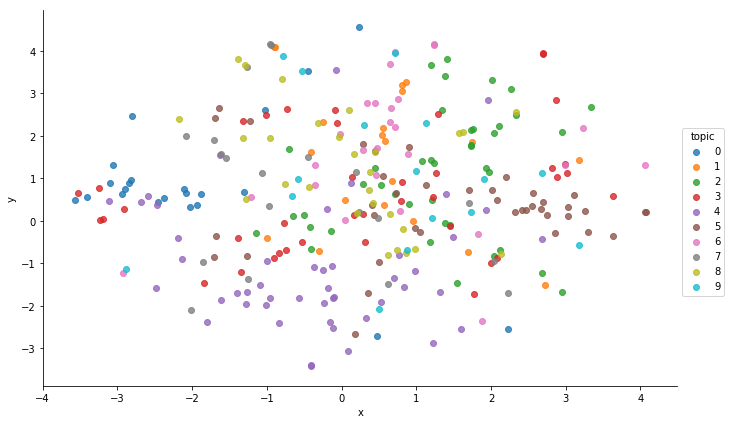

In [12]:
tsne_vectors = manifold.TSNE(perplexity=100, random_state=0).fit_transform(docvecs)
df = pd.DataFrame(data=np.c_[tsne_vectors, doc_topics], columns= ['x', 'y', 'topic'])
df.topic = df.topic.astype(int)
sns.lmplot(data=df, x='x', y='y', hue='topic', fit_reg=False, size=6, aspect=1.6)

### Compute cosine similarity from doc2vec

In [72]:
from gensim.models import KeyedVectors

def compute_similarity(docvecs):
    def compute_one(docvec):
        return (KeyedVectors.cosine_similarities(docvec, docvecs).reshape(1, len(docvecs)) + 1) / 2
    
    return np.concatenate([compute_one(docvec) for docvec in docvecs])

In [73]:
distance_matrix = compute_similarity(docvecs)

### Compare intra-topic similarity vs. inter-topic similarity

In [74]:
def compute_sim_docs(distance_matrix, topic_id, doc_topics):
    'Return average similarity between pairs of documents within a topic.'
    doc_indices = [i for i in range(len(doc_topics)) if doc_topics[i] == topic_id]
    distances = [distance_matrix[i][j] for i in doc_indices for j in doc_indices]
    intra_sim = sum(distances) / len(distances)
    
    outdoc_indices = [i for i in range(len(doc_topics)) if doc_topics[i] != topic_id]
    distances = [distance_matrix[i][j] for i in doc_indices for j in outdoc_indices]
    inter_sim = sum(distances) / len(distances)
        
    return intra_sim, inter_sim

In [75]:
for i in range(10):
    print('topic', i)
    print(compute_sim_docs(distance_matrix, i, doc_topics))
    print()

topic 0
(0.7149010830181689, 0.5774761676846805)

topic 1
(0.6747659504413605, 0.6052837078432952)

topic 2
(0.622036737994308, 0.5981373670428068)

topic 3
(0.6123142439350339, 0.5977128121464996)

topic 4
(0.6340632360144001, 0.5844602394780075)

topic 5
(0.6476136219128966, 0.5979022615173688)

topic 6
(0.6504874433550609, 0.59635850308167)

topic 7
(0.6278826218098402, 0.5928537863971931)

topic 8
(0.6584859201114397, 0.6032975758347628)

topic 9
(0.6357865331228822, 0.6004841682619192)

